<a href="https://colab.research.google.com/github/2813/dls-homework/blob/main/%5Bhomework%5Ddense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

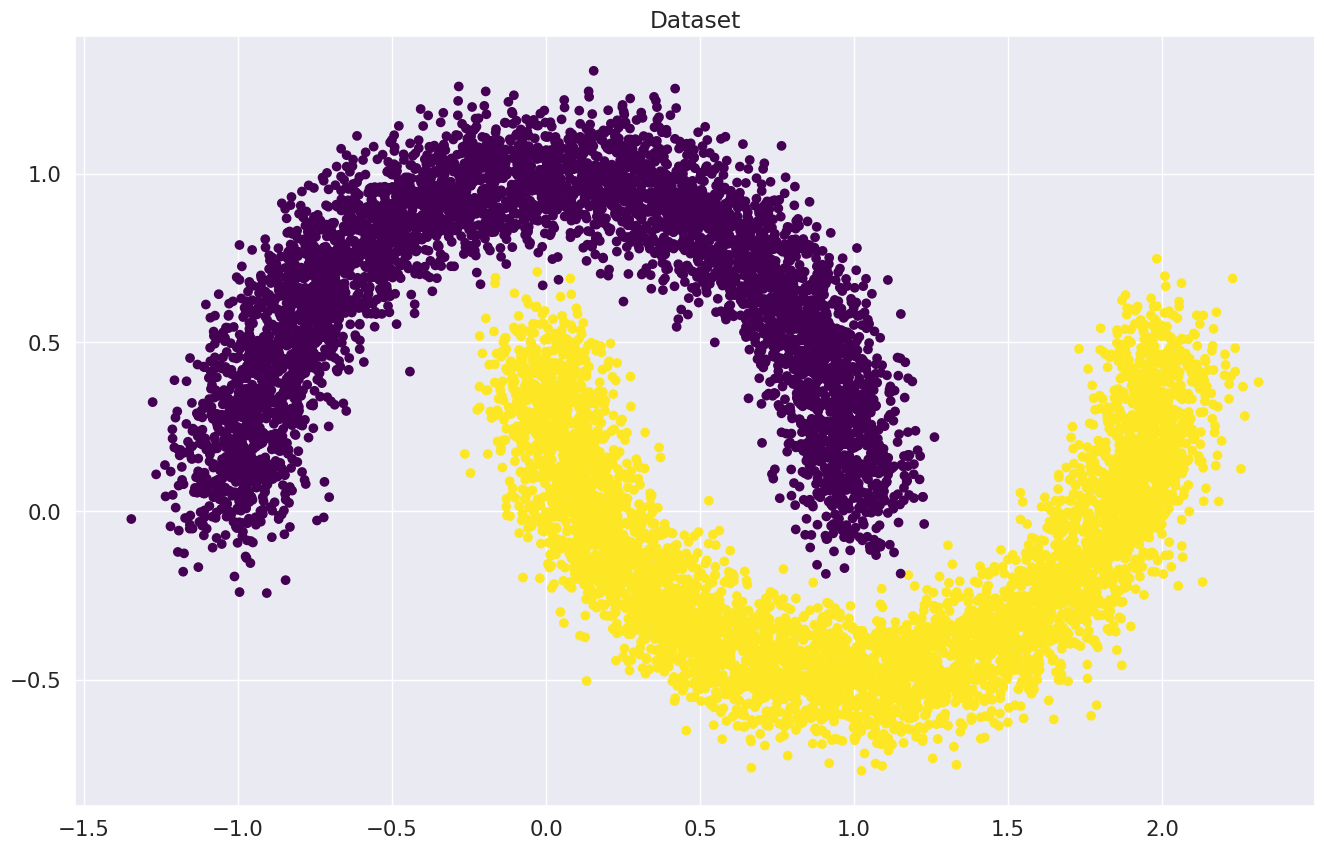

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.FloatTensor(X_train)# YOUR CODE GOES HERE
y_train_t =  torch.FloatTensor(y_train)# YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val)# YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features)) # размерность W равна количеству входных "фичей"
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # размерность b это размерность строк в XW, т.е. количество выходных "фич"
            #self.bias_term = nn.Parameter(torch.ones(1, out_features)) # тоже самое, только вместо рандома все в единичках

    def forward(self, x):
        x = torch.mv(x, self.weights) # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
list(linear_regression.parameters()) # видим, что ТРИ обучаемых параметра. Действительно W.size + b.size

[Parameter containing:
 tensor([-1.5006, -1.8715], requires_grad=True),
 Parameter containing:
 tensor([1.2915], requires_grad=True)]

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6328125
Iteration: 100
Batch accuracy: 0.8359375
Iteration: 200
Batch accuracy: 0.875
Iteration: 300
Batch accuracy: 0.9296875
Iteration: 400
Batch accuracy: 0.90625

Iteration: 401.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**  637  (при разных запусках получается разное кол-во итераций) от 400 до 800.

### Визуализируем результаты

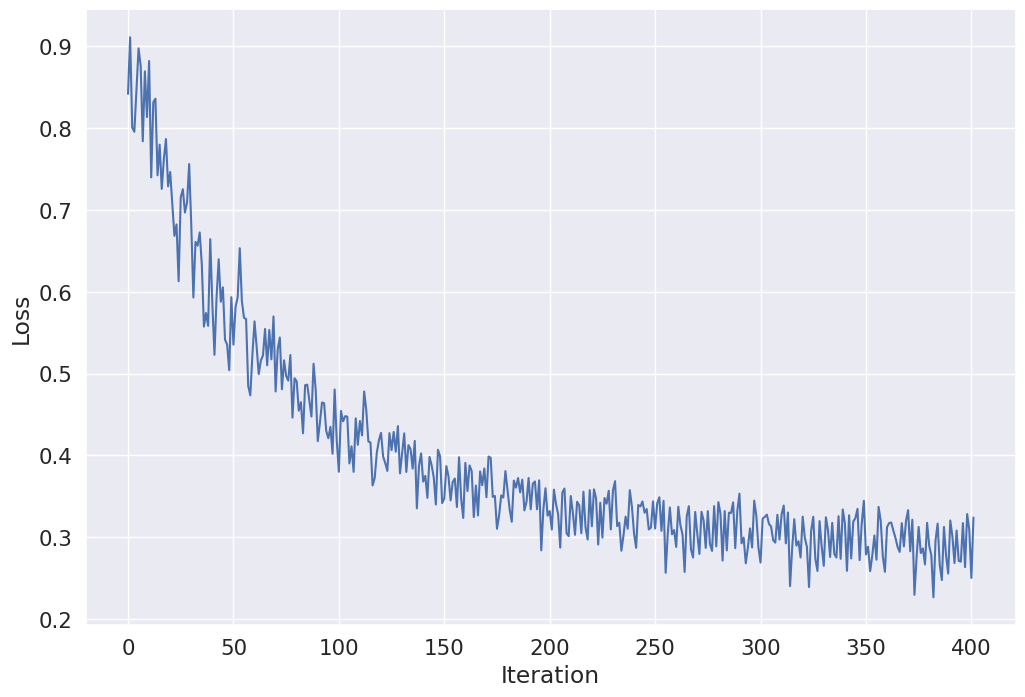

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

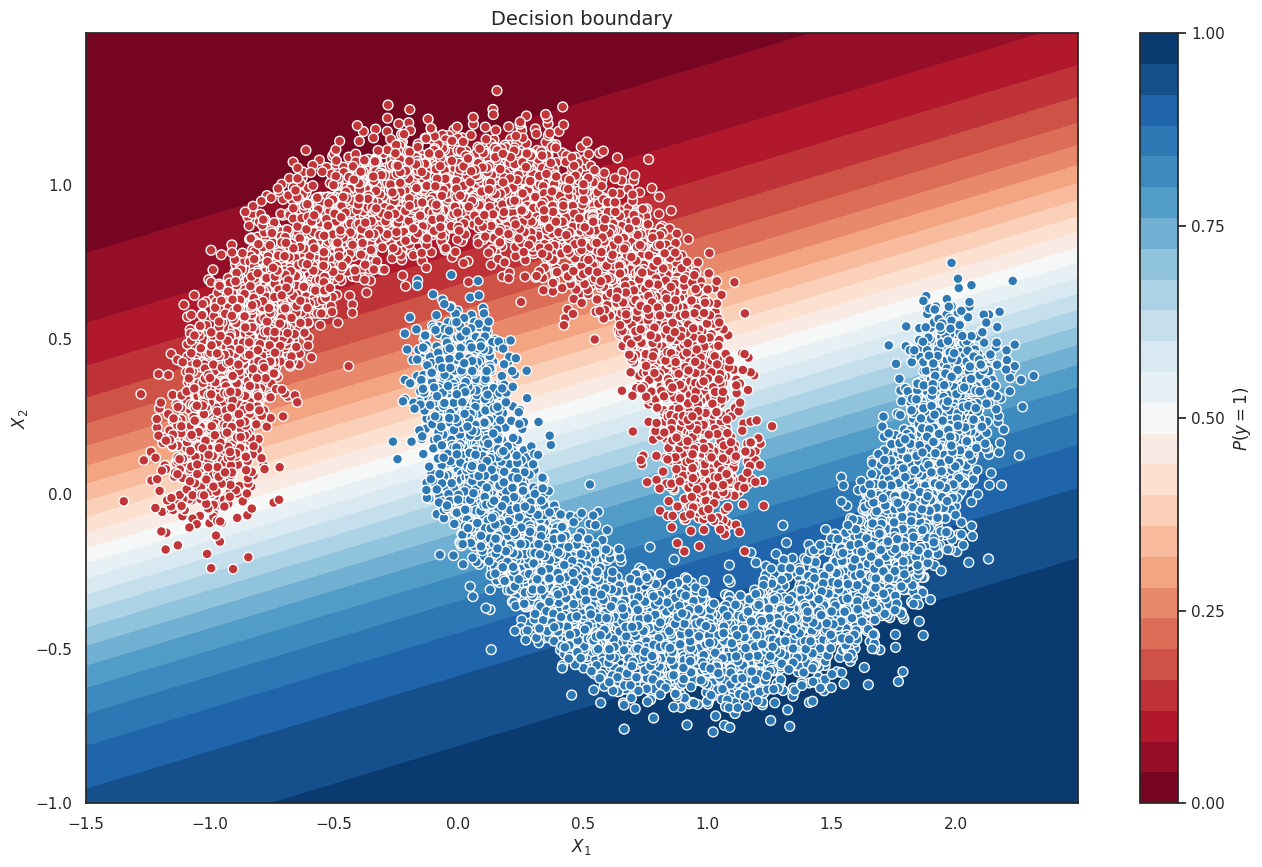

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # Получаем предсказания для отдельного батча,
        #  Применяем к нему сигмоиду, чтобы получить вероятность
        preds = F.sigmoid(model(x_batch)) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

# Формируем вектор из истинных значений, склеивая их аналогично примеру выше
# Таким образом, получим два вектора размера 2500, в одном будут
#  истинные значения из датасета, а во втором предсказания
y_val = np.array([])
for _, y_batch in val_dataloader:
  y_val = np.hstack((y_val, y_batch.numpy().flatten()))

# в predictions у нас вероятности
predictions = predict(val_dataloader, linear_regression)
# формируем вектор предсказаний, где true там где вероятность больше 0.5 и false в противном случае
d = [p>0.5 for p in predictions]


accuracy_score(y_val, d)


0.8904

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.88  (есть элемент случайности, поэтому после перезапуска цифра может слегка меняться)

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)# YOUR CODE
valid_dataloader =  DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2) # YOUR CODE

100%|██████████| 9912422/9912422 [00:00<00:00, 74240087.79it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15074128.15it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30188007.53it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4640810.91it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU

model = nn.Sequential (
    nn.Flatten(),
    nn.Linear(784, 128),  # 28*28*1 = 784. картинка 28 на 28 с одним каналом
    activation(),
    nn.Linear(128,10)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
model.to(device)
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(device))
            else:
              # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()  # сумма всех случаев, когда предсказания совпали
            all =  len(y_batch.to(device)) # величина всего батча
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8853166666666666
Loader: valid. Accuracy: 0.9359
Epoch: 2
Loader: train. Accuracy: 0.9435333333333333
Loader: valid. Accuracy: 0.9587
Epoch: 3
Loader: train. Accuracy: 0.95955
Loader: valid. Accuracy: 0.9665
Epoch: 4
Loader: train. Accuracy: 0.96825
Loader: valid. Accuracy: 0.9695
Epoch: 5
Loader: train. Accuracy: 0.9739666666666666
Loader: valid. Accuracy: 0.9735
Epoch: 6
Loader: train. Accuracy: 0.9775166666666667
Loader: valid. Accuracy: 0.9728
Epoch: 7
Loader: train. Accuracy: 0.9805333333333334
Loader: valid. Accuracy: 0.9694
Epoch: 8
Loader: train. Accuracy: 0.9828166666666667
Loader: valid. Accuracy: 0.9744
Epoch: 9
Loader: train. Accuracy: 0.9834333333333334
Loader: valid. Accuracy: 0.9729
Epoch: 10
Loader: train. Accuracy: 0.9858666666666667
Loader: valid. Accuracy: 0.9748


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
def test_activation_function(activation):
    model_with_activation = nn.Sequential (
        nn.Flatten(),
        nn.Linear(784, 128),  # 28*28*1 = 784. картинка 28 на 28 с одним каналом
        activation(),
        nn.Linear(128,10)
    )
    model_with_activation.to(device)
    # все копируем, что было выше
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_with_activation.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model_with_activation.train()
                    optimizer.zero_grad()
                    outp = model_with_activation(x_batch.to(device))
                else:
                    model_with_activation.eval()
                    with torch.no_grad():
                        outp = model_with_activation(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = (preds == y_batch.to(device)).sum()
                all =  len(y_batch.to(device))
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]


In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy  = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)


Epoch: 1
Loader: train. Accuracy: 0.8765666666666667
Loader: valid. Accuracy: 0.91
Epoch: 2
Loader: train. Accuracy: 0.9043666666666667
Loader: valid. Accuracy: 0.9098
Epoch: 3
Loader: train. Accuracy: 0.9083833333333333
Loader: valid. Accuracy: 0.9047
Epoch: 4
Loader: train. Accuracy: 0.9119666666666667
Loader: valid. Accuracy: 0.9159
Epoch: 5
Loader: train. Accuracy: 0.9148666666666667
Loader: valid. Accuracy: 0.9162
Epoch: 6
Loader: train. Accuracy: 0.91385
Loader: valid. Accuracy: 0.9133
Epoch: 7
Loader: train. Accuracy: 0.9158
Loader: valid. Accuracy: 0.9178
Epoch: 8
Loader: train. Accuracy: 0.9165
Loader: valid. Accuracy: 0.9133
Epoch: 9
Loader: train. Accuracy: 0.91645
Loader: valid. Accuracy: 0.9173
Epoch: 10
Loader: train. Accuracy: 0.9181
Loader: valid. Accuracy: 0.9166
Epoch: 1
Loader: train. Accuracy: 0.8807833333333334
Loader: valid. Accuracy: 0.9233
Epoch: 2
Loader: train. Accuracy: 0.9341
Loader: valid. Accuracy: 0.9488
Epoch: 3
Loader: train. Accuracy: 0.95295
Loader: v

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

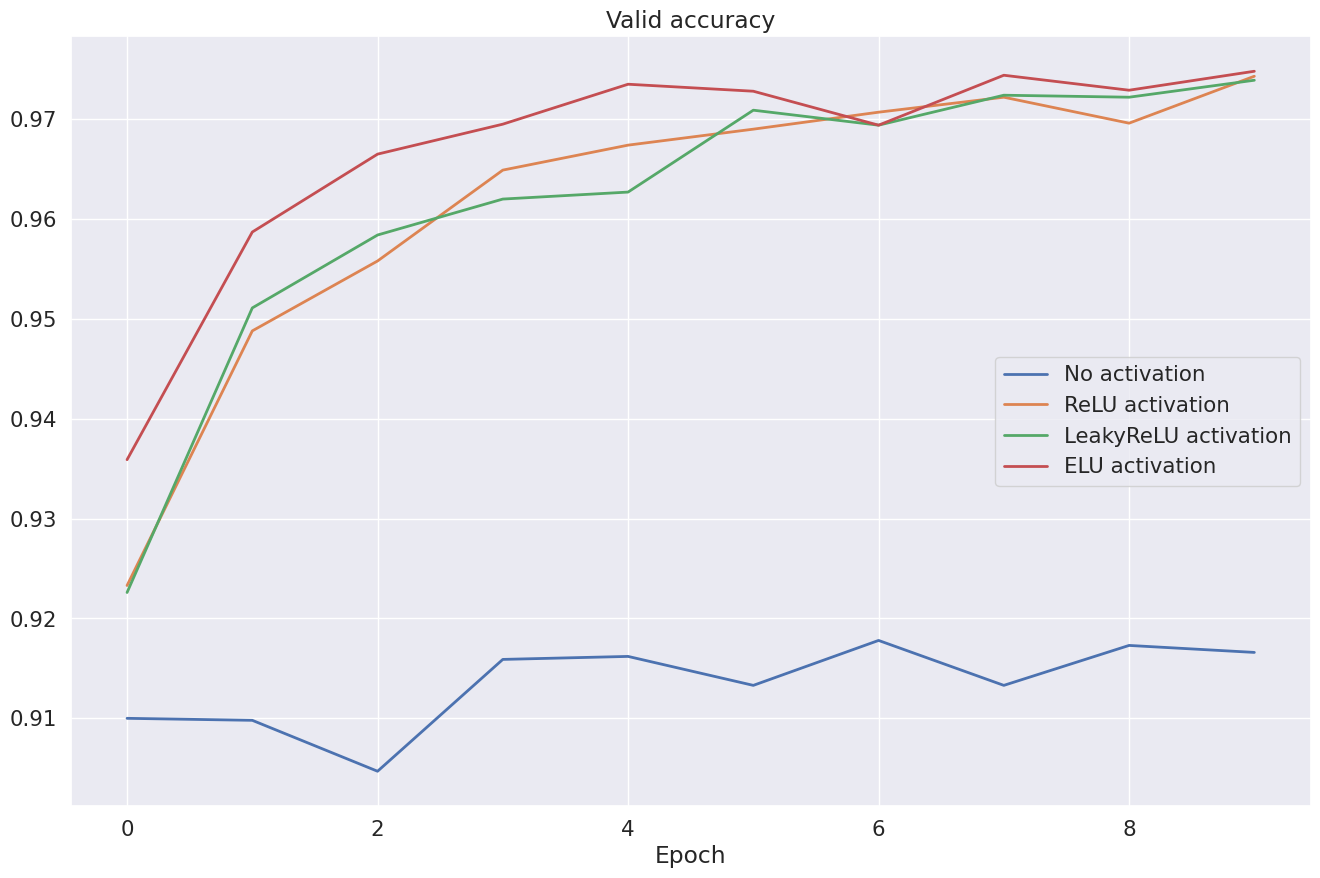

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

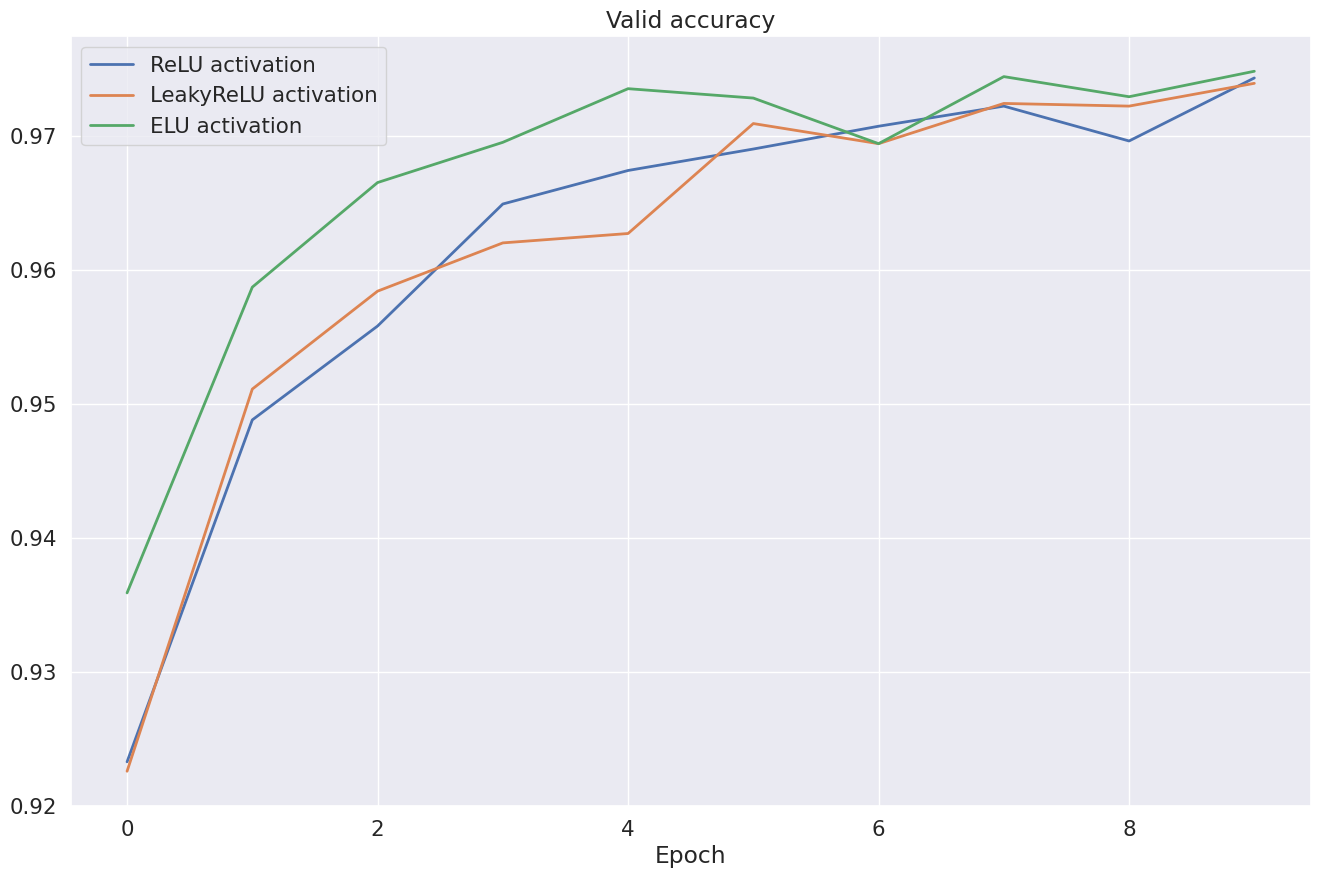

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU  (в конкретном запуске получился ELU, но все три фукции ведут себя похоже и при следующем вызове впереди сомсем немного может оказаться другая функция)

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-03 01:37:35--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   210KB/s    in 0.2s    

2023-11-03 01:37:36 (210 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



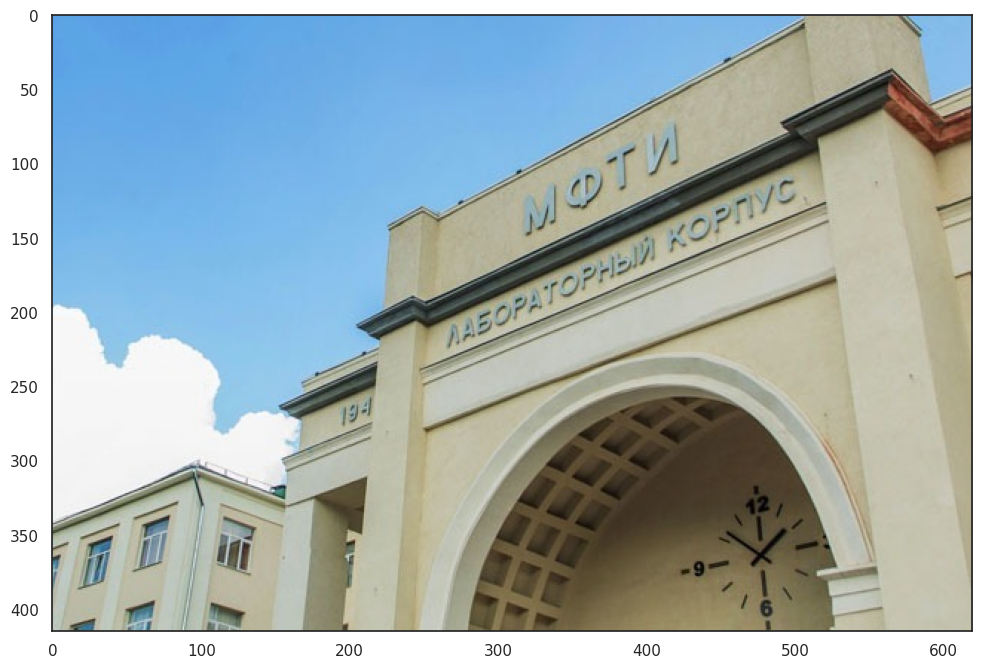

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
   [0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

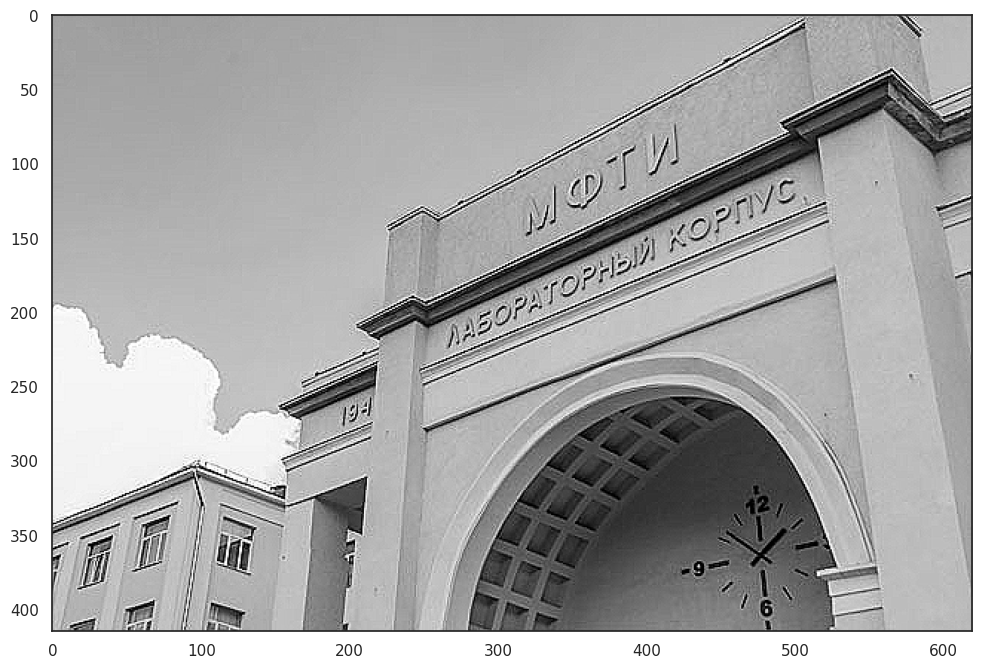

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1 - E, 2 - Д, 3 - А, 4 - В, 5 - Б, 6 - Г

см. https://setosa.io/ev/image-kernels/ там можно поиграться с разными кернерами и их назначение более очевидно становится

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 3)#YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1) # слайд 1, по умолчанию он равняется kernel_size.
        #От этого зависит размер входа на первый линейный слой. Возможно у вас он другой размерности
        self.fc1 = nn.Linear(16*22*22,120) #распечатали x.shape и посмотрели какой размерности будет х.
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        #print(x.shape)
        x = torch.flatten(x, 1) # или x = x.view(-1, 22 * 22 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(device))
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()  # количество элементов на коротом есть совпадение
            all =  len(y_batch.to(device)) # общая величина батча
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9374666666666667
Loader: valid. Accuracy: 0.9745
Epoch: 2
Loader: train. Accuracy: 0.9820833333333333
Loader: valid. Accuracy: 0.9859
Epoch: 3
Loader: train. Accuracy: 0.98755
Loader: valid. Accuracy: 0.9865
Epoch: 4
Loader: train. Accuracy: 0.99085
Loader: valid. Accuracy: 0.9886
Epoch: 5
Loader: train. Accuracy: 0.9922
Loader: valid. Accuracy: 0.9894
Epoch: 6
Loader: train. Accuracy: 0.9940333333333333
Loader: valid. Accuracy: 0.9887
Epoch: 7
Loader: train. Accuracy: 0.9954833333333334
Loader: valid. Accuracy: 0.9887
Epoch: 8
Loader: train. Accuracy: 0.9963666666666666
Loader: valid. Accuracy: 0.988
Epoch: 9
Loader: train. Accuracy: 0.99605
Loader: valid. Accuracy: 0.9888
Epoch: 10
Loader: train. Accuracy: 0.9968333333333333
Loader: valid. Accuracy: 0.9887


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

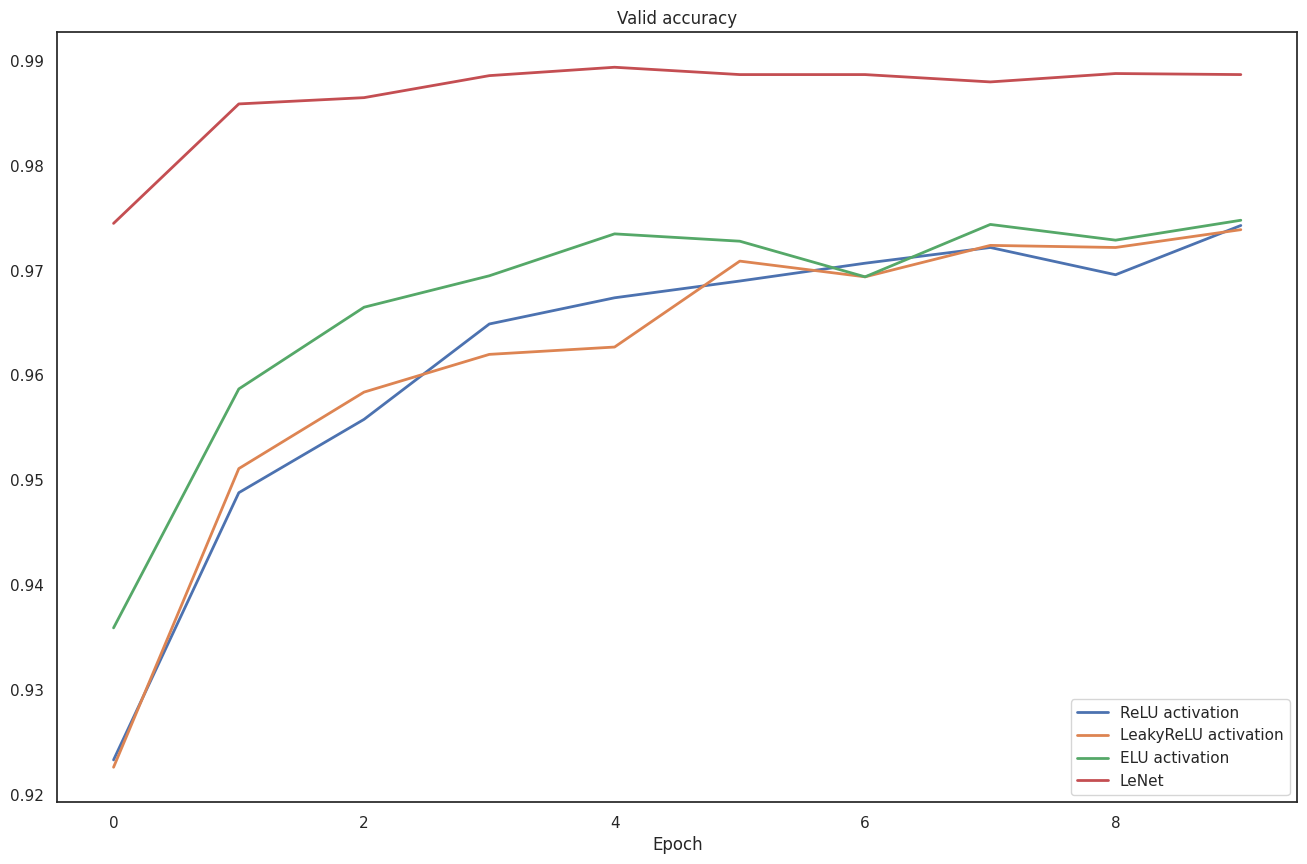

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**  0.98